In [1]:
import json
import pandas as pd
from pymongo import MongoClient
import numpy as np
import seaborn as sns


from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
DUMPDATA = False

In [3]:
def _connect_mongo(host, port, username, password, db):
    """ A util for making a connection to mongo """

    if username and password:
        mongo_uri = 'mongodb://%s:%s@%s:%s/%s' % (username, password, host, port, db)
        conn = MongoClient(mongo_uri)
    else:
        conn = MongoClient(host, port)


    return conn[db]


def read_mongo(db, collection, query={}, host='localhost', port=27017, username=None, password=None, no_id=True):
    """ Read from Mongo and Store into DataFrame """

    # Connect to MongoDB
    db = _connect_mongo(host=host, port=port, username=username, password=password, db=db)

    # Make a query to the specific DB and Collection
    cursor = db[collection].find(query)

    # Expand the cursor and construct the DataFrame
    df =  pd.DataFrame(list(cursor))

    # Delete the _id
    if no_id:
        del df['_id']

    return db, df


def group_eb_pb_by_celltype(datasets_df_dic, score_thr):
    skids_epg = [1568214, 3457743, 4087066, 437814, 861090, 4210786, 676911, 1274528, 1274114, 1274268, 4040702, 854150, 854156]
    skids_peg = [1032767, 3849973, 963438, 3512247]
    skids_pen1 = [649823, 668576, 3338987, 3423772, 525851, 607812, 827466, 828911]
    skids_pen2 = [2703303, 806288, 3286828, 3349747, 659759, 3491680, 1639675, 1625086]
    allregions = pd.concat(datasets_df_dic.values())
    allregions['tpcount'] = allregions.tp_gt.apply(lambda x: len(x))
    allregions['gtcount_joint'] = allregions.groupby(['skel_id'])['gtcount'].transform('sum')
    allregions['tpcount_joint'] = allregions.groupby(['skel_id'])['tpcount'].transform('sum')
    allregions['fpcount_joint'] = allregions.groupby(['skel_id'])['fpcount'].transform('sum')
    allregions['fncount_joint'] = allregions.groupby(['skel_id'])['fncount'].transform('sum')
    allregions = allregions[allregions.brain_region != 'eb']

    entries = ['gtcount_joint', 'tpcount_joint','fpcount_joint', 'fncount_joint', 'skel_id', 'brain_region']
    allregions = allregions[entries]
    allregions.loc[allregions.skel_id.isin(skids_epg), 'celltype'] = 'epg'
    allregions.loc[allregions.skel_id.isin(skids_peg), 'celltype'] = 'peg'
    allregions.loc[allregions.skel_id.isin(skids_pen1), 'celltype'] = 'pen1'
    allregions.loc[allregions.skel_id.isin(skids_pen2), 'celltype'] = 'pen2'
    allregions = allregions[(allregions.brain_region != 'calyx') & (allregions.brain_region != 'lh')]

    res = allregions.groupby(['celltype']).sum()

    res['precision'] = res['tpcount_joint']/(res['tpcount_joint'] + res['fpcount_joint'])
    res['recall'] = res['tpcount_joint']/(res['tpcount_joint'] + res['fncount_joint'])
    res['fscore'] = 2*res['precision']*res['recall']/(res['precision'] + res['recall'])

    res = res.reset_index()
    res['score_thr'] = score_thr
    return res


def plot_celltypes(celltype_dic, labellines=False, labelfscore=False):
    sns.set(font_scale=2.0)
    sns.set_style("ticks")
    plt.rcParams['svg.fonttype'] = 'none'
    current_palette = sns.color_palette("colorblind")
    sns.set_palette(current_palette)


    plt.figure(figsize=(10, 10))
    markers = ['o', 's', 'D', '^', '*', 'd']
    ii = 0
    for key, df in celltype_dic.items():
        df = df.sort_values(by='score_thr', ascending=False)
        best_row = df.loc[df['fscore'].idxmax()]
        fscore = best_row['fscore']
        precision = best_row['precision']
        recall = best_row['recall']
        score_thr = best_row['score_thr']
        if 'gtcount_joint' in best_row.keys():
            print(best_row.gtcount_joint)
        if labelfscore:
            labelfscore = f'{fscore:0.2}'
        else:
            labelfscore = None
        
        if labellines:
            labellines = key
        else:
            labellines = None
        p = plt.plot(df['recall'], df['precision'], label=labellines, linewidth=3.)
        print(f"best fscore: {fscore:0.4}, precision: {precision:0.4}, recall: {recall:0.2} with score threshold: {score_thr}")
        plt.scatter(best_row['recall'], best_row['precision'], marker=markers[ii],  facecolors='none', edgecolors=p[-1].get_color(), s=100, linewidth=4, label=labelfscore)
        ii += 1
        key = key.replace(' ', '_')
#         df.to_csv(f'data/celltypes/{key}.csv', index=False, columns=['fscore', 'precision', 'recall', 'score_thr'])
    plt.xlabel(r'$\mathrm{Recall}$')
    plt.ylabel(r'$\mathrm{Precision}$')
    plt.xlim([0, 1.0])
    plt.ylim([0, 1.0])
    sns.despine()
    plt.axes().set_aspect(1.0)
    if labellines is not None:
        plt.legend(title='Cell types')
        outputfile = 'figures/celltypes/synapse_complete_precision_recall_lines.svg'
    else:
        plt.legend(title='f-score')
        outputfile = 'figures/celltypes/synapse_complete_precision_recall_fscore.svg'
    
#     plt.savefig(outputfile)

In [4]:
if DUMPDATA:

    datasets_col_dic = {
        'Kenyon cells': 'false_calyx_kc_ids_full_lsd_local_filtered2_1',
        'Olfactory projection neurons': 'false_lh_done_pn_ids_full_lsd_local_filtered2_1',
        'PB': 'false_pb_neuron_ids_full_lsd_local_filtered2_1',
        'EB': 'false_eb_neuron_ids_full_lsd_local_filtered2_1',
    }
    datasets_df_dic = {}
    db_col = 'summary'

    with open('../dbconfigsynful.json') as f:
        db_host = json.load(f)['db_host']

    for key, db_name in datasets_col_dic.items():
        print('Loading data for', key)
        db, df = read_mongo(db_name, db_col, host=db_host, no_id=True)
        df.drop_duplicates(inplace=True)
        datasets_df_dic[key] = df
        print('total items in dataframe: {}'.format(len(df)))
        print(np.unique(df.gtcount))
    score_thresholds = np.unique(datasets_df_dic['PB'].score_thr)
    celltype_dic = datasets_df_dic.copy()
    del celltype_dic['PB']
    del celltype_dic['EB']

In [5]:
if DUMPDATA:
    datasets_col_dic = {
        'pb': 'false_pb_neuron_ids_full_lsd_local_filtered2_1',
        'eb': 'false_eb_neuron_ids_full_lsd_local_filtered2_1'
    }
    all_dfs = []
    for score_thr in score_thresholds:
        datasets_df_dic = {}
        for key, db_name in datasets_col_dic.items():
            db_col = 'lsd_local_filtered2.thr{}'.format(1000 * score_thr)
            db, df = read_mongo(db_name, db_col, host=db_host, no_id=True)
            df['brain_region'] = key
            datasets_df_dic[key] = df
        all_dfs.append(group_eb_pb_by_celltype(datasets_df_dic, score_thr))
    df = pd.concat(all_dfs, ignore_index=True)

In [6]:
inputfile = 'synapse_complete_df_curves.csv'
if DUMPDATA:
    df.to_csv(inputfile, index=False)
df = pd.read_csv(inputfile)
celltype_dic = {}
celltype_dic['EP-G'] = df[df.celltype == 'epg']
celltype_dic['P-EN1'] = df[df.celltype == 'pen1']
celltype_dic['P-EN2'] = df[df.celltype == 'pen2']
celltype_dic['P-EG'] = df[df.celltype == 'peg']

52765
best fscore: 0.6636, precision: 0.6975, recall: 0.63 with score threshold: 6
13885
best fscore: 0.6371, precision: 0.6741, recall: 0.6 with score threshold: 10
11059
best fscore: 0.639, precision: 0.6841, recall: 0.6 with score threshold: 30
5503
best fscore: 0.5882, precision: 0.6466, recall: 0.54 with score threshold: 5
52765
best fscore: 0.6636, precision: 0.6975, recall: 0.63 with score threshold: 6
13885
best fscore: 0.6371, precision: 0.6741, recall: 0.6 with score threshold: 10
11059
best fscore: 0.639, precision: 0.6841, recall: 0.6 with score threshold: 30
5503
best fscore: 0.5882, precision: 0.6466, recall: 0.54 with score threshold: 5


/groups/funke/home/buhmannj/anaconda2/envs/newdaisy/lib/python3.6/site-packages/ipykernel_launcher.py:105: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/groups/funke/home/buhmannj/anaconda2/envs/newdaisy/lib/python3.6/site-packages/ipykernel_launcher.py:105: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


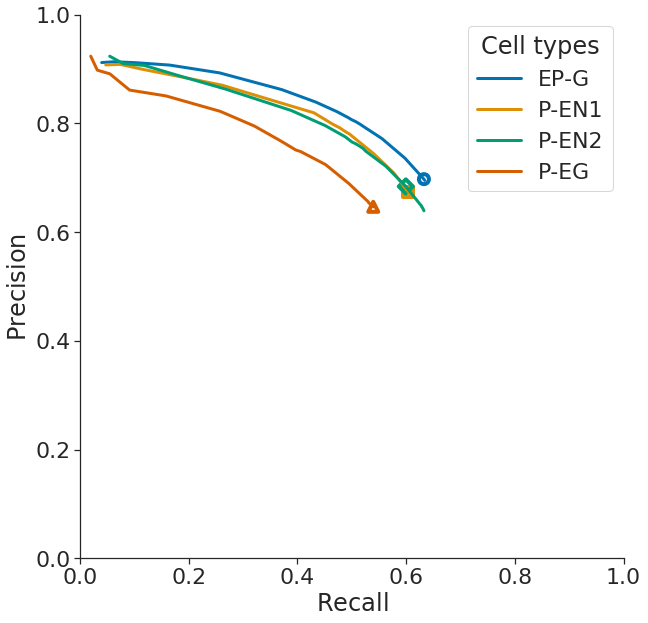

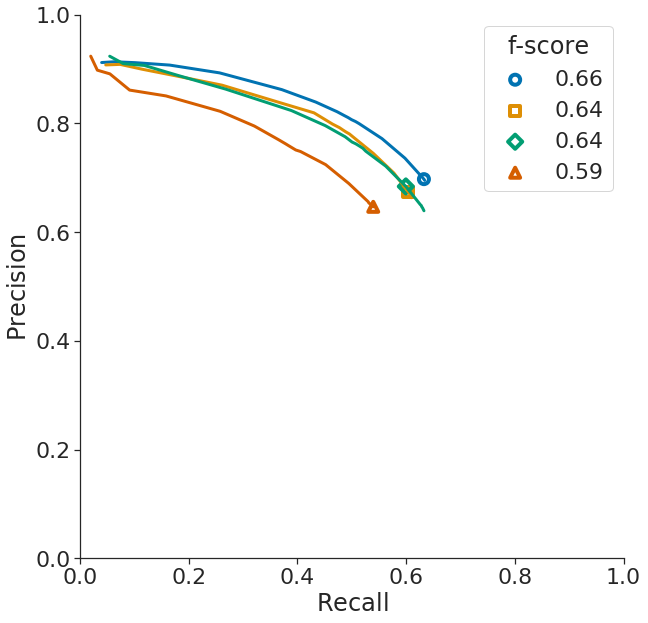

In [7]:
plot_celltypes(celltype_dic, labellines=True)
plot_celltypes(celltype_dic, labelfscore=True)